<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W3D3_NetworkCausality/W3D3_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy 2020 -- Week 3 Day 3 Tutorial 3
# Causality Day - Simultaneous fitting and Granger causality

---
## Overall tutorial objectives

This is tutorial 3 on our day of examining causality. Below is the high level outline of what we'll cover today, with the sections we will focus on in this notebook in bold:

1.   Master definitions of causality
2.   Understand that estimating causality is possible
3.   Learn 5 different methods and understand when they fail
    1. perturbations
    2. correlations
    3. **simultaneous fitting/regression**
    4. **Granger causality**
    5. instrumental variables

### Notebook 3 objectives

In tutorial 2 we explored correlation as an approximation for causation and learned that correlation $\neq$ causation for larger networks. However, computing correlations is a rather simple approach, and you may be wondering: will more sophisticated techniques allow us to better estimate causality? Here we'll use some common advanced (but controversial) methods that estimate causality from observational data. These methods rely on fitting a function to our data directly, instead of trying to use perturbations or correlations. Since we have the full closed-form equation of our system, we can try these methods and see how well they work in estimating causal connectivity when there are no perturbations. Specifically, we will:

- Learn about more advanced (but also controversial) techniques for estimating causality
    - conditional probabilities (**regression**)
    - **Granger causality**
- Explore limitations and failure modes of these advanced techniques
    - understand the problem of **omitted variable bias**


# Setup

In [1]:
import matplotlib.pyplot as plt

import numpy as np
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge, LinearRegression, ElasticNet, Lasso

import ipywidgets as widgets
import matplotlib.patches as patches

!pip install statsmodels
from statsmodels.tsa.stattools import grangercausalitytests

     |███████▏                        | 1.9 MB 18.5 MB/s eta 0:00:01

     |███████████████████▉            | 5.4 MB 18.5 MB/s eta 0:00:01

     |████████████████████████████████| 8.7 MB 18.5 MB/s eta 0:00:01

     |████████████████████████████████| 8.7 MB 18.5 MB/s 


     |████████████████████████████████| 231 kB 63.2 MB/s 


     |█▎                              | 409 kB 57.4 MB/s eta 0:00:01

     |████████████▋                   | 4.0 MB 57.4 MB/s eta 0:00:01

     |█████████████████████████▏      | 7.9 MB 57.4 MB/s eta 0:00:01

     |████████████████████████████████| 10.1 MB 57.4 MB/s eta 0:00:01

     |████████████████████████████████| 10.1 MB 57.4 MB/s 


     |████████████████████████████████| 510 kB 60.3 MB/s 


In [2]:
#@title Figure Settings
%matplotlib inline
fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
%config InlineBackend.figure_format = 'retina'

In [3]:
# @title Helper Functions
def sigmoid(x):
    """
    Compute sigmoid nonlinearity element-wise on x.
    
    Args:
        x (np.ndarray): the numpy data array we want to transform
    Returns
        (np.ndarray): x with sigmoid nonlinearity applied
    """
    return 1 / (1 + np.exp(-x))


def logit(x):
    """
    
    Applies the logit (inverse sigmoid) transformation
    
    Args:
        x (np.ndarray): the numpy data array we want to transform
    Returns
        (np.ndarray): x with logit nonlinearity applied
    """
    return np.log(x/(1-x))

def create_connectivity(n_neurons, random_state=42):
    """
    Generate our nxn causal connectivity matrix.

    Args:
        n_neurons (int): the number of neurons in our system.
        random_state (int): random seed for reproducibility

    Returns:
        A (np.ndarray): our 0.1 sparse connectivity matrix
    """
    np.random.seed(random_state)
    A_0 = np.random.choice([0,1], size=(n_neurons, n_neurons), p=[0.9, 0.1])

    # set the timescale of the dynamical system to about 100 steps
    _, s_vals , _ = np.linalg.svd(A_0)
    A = A_0 / (1.01 * s_vals[0]) 

    # _, s_val_test, _ = np.linalg.svd(A)
    # assert s_val_test[0] < 1, "largest singular value >= 1"

    return A


def see_neurons(A, ax, ratio_observed=1):
    """
    Visualizes the connectivity matrix.

    Args:
        A (np.ndarray): the connectivity matrix of shape (n_neurons, n_neurons)
        ax (plt.axis): the matplotlib axis to display on

    Returns:
        Nothing, but visualizes A.
    """
    n = len(A)

    ax.set_aspect('equal')
    thetas = np.linspace(0,np.pi*2,n,endpoint=False )
    x,y = np.cos(thetas),np.sin(thetas),
    for i in range(n):
        for j in range(n):
            if A[i,j]>0:
                ax.arrow(x[i],y[i],x[j]-x[i],y[j]-y[i],color='k',head_width=.05,
                        width = A[i,j]/25,shape='right', length_includes_head=True,
                         alpha = .2)
    if ratio_observed<1:
      nn = int(n*ratio_observed)
      ax.scatter(x[:nn],y[:nn],c='r',s=150, label='Observed')
      ax.scatter(x[nn:],y[nn:],c='b',s=150, label='Unobserved')
      ax.legend(fontsize=15)
    else:
      ax.scatter(x,y,c='k',s=150)
    ax.axis('off')


def simulate_neurons(A, timesteps, random_state=42):
    """
    Simulates a dynamical system for the specified number of neurons and timesteps.

    Args:
        A (np.array): the connectivity matrix
        timesteps (int): the number of timesteps to simulate our system.
        random_state (int): random seed for reproducibility
        
    Returns:
        - X has shape (n_neurons, timeteps).
    """
    np.random.seed(random_state)

    
    n_neurons = len(A)
    X = np.zeros((n_neurons, timesteps))

    for t in range(timesteps-1):
        # solution
        epsilon = np.random.multivariate_normal(np.zeros(n_neurons), np.eye(n_neurons))
        X[:, t+1] = sigmoid(A.dot(X[:,t]) + epsilon)

        assert epsilon.shape == (n_neurons,)
    return X


def correlation_for_all_neurons(X):
  """Computes the connectivity matrix for the all neurons using correlations

    Args:
        X: the matrix of activities

    Returns:
        estimated_connectivity (np.ndarray): estimated connectivity for the selected neuron, of shape (n_neurons,)
        """
  n_neurons = len(X)
  S = np.concatenate([X[:, 1:], X[:, :-1]], axis=0)
  R = np.corrcoef(S)[:n_neurons, n_neurons:] 
  return R


def get_sys_corr(n_neurons, timesteps, random_state=42, neuron_idx=None):
    """
    A wrapper function for our correlation calculations between A and R.

    Args:
        n_neurons (int): the number of neurons in our system.
        timesteps (int): the number of timesteps to simulate our system.
        random_state (int): seed for reproducibility
        neuron_idx (int): optionally provide a neuron idx to slice out

    Returns:
        A single float correlation value representing the similarity between A and R
    """
    
    A = create_connectivity(n_neurons,random_state)
    X = simulate_neurons(A, timesteps)

    R = correlation_for_all_neurons(X)

    return np.corrcoef(A.flatten(), R.flatten())[0,1]

def get_regression_corr(n_neurons, A, X, observed_ratio, regression_args, neuron_idx=None):
    """

    A wrapper function for our correlation calculations between A and the V estimated
    from regression.

    Args:
        n_neurons (int): the number of neurons in our system.
        A (np.array): the true connectivity
        X (np.array): the simulated system
        observed_ratio (float): the proportion of n_neurons observed, must be between 0 and 1.
        regression_args (dict): dictionary of lasso regression arguments and hyperparameters
        neuron_idx (int): optionally provide a neuron idx to compute connectivity for

    Returns:
        A single float correlation value representing the similarity between A and R
    """
    assert (observed_ratio > 0) and (observed_ratio <= 1)
    
    sel_idx = np.clip(int(n_neurons*observed_ratio), 1, n_neurons)
    selected_X = X[:sel_idx, :]
    selected_connectivity = A[:sel_idx, :sel_idx]

    estimated_selected_connectivity = get_regression_estimate(selected_X, neuron_idx=neuron_idx)
    if neuron_idx is None:
        return np.corrcoef(selected_connectivity.flatten(), 
                           estimated_selected_connectivity.flatten())[1,0], estimated_selected_connectivity
    else:
        return np.corrcoef(selected_connectivity[neuron_idx, :], 
                           estimated_selected_connectivity)[1,0], estimated_selected_connectivity

def plot_connectivity_matrix(A, ax=None):
  """Plot the (weighted) connectivity matrix A as a heatmap."""
  if ax is None:
    ax = plt.gca()
  lim = np.abs(A).max()
  ax.imshow(A, vmin=-lim, vmax=lim, cmap="coolwarm")

# Regression




You may be familiar with the idea that correlation only implies causation when there no hidden *confounders*. This aligns with our intuition that correlation only implies causality when no alternative variables could explain away a correlation.

**A confounding example**:
Suppose you observe that people who sleep more do better in school. It's a nice correlation. But what else could explain it? Maybe people who sleep more are richer, don't work a second job, and have time to actually do homework. If you want to ask if sleep *causes* better grades, and want to answer that with corelations, you have to control for all possible confounds.

A confound is any variable that affects both the outcome and your original covariate. In our example, these are things that affect both sleep and grades. 

**Controlling for a confound**: 
Confonds can be controlled for by adding them as covariates in a regression. But for your coefficients to be causal effects, you need two things:
 
1.   **All** confounds are included as covariates
2.   Your regression assumes the same mathematical form of how covariates relate to outcomes (linear, GLM, etc.)
3.   No covariates are caused *by* the treatment (original variable) and the outcome. These are "colliders"; we won't introduce it today (but Google it on your own time!)

In the real world it is very hard to guarantee these conditions are met. In the brain it's even harder (as we can't measure all neurons). Luckily today we simulated the system ourselves.

Video available at https://youtu.be/UNaE3yYBCwY


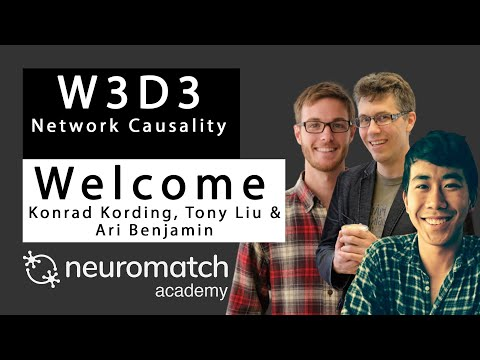

In [4]:
#@title Video 
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="UNaE3yYBCwY", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

## Recovering connectivity by model fitting

Recall that in our system each neuron effects every other via:

$$
\vec{x}_{t+1} = \sigma(A\vec{x}_t + \epsilon_t), 
$$

Our system is a closed system, too, so there are no omitted variables. The regression coefficients should be the causal effect. Are they?

## Exercise 1: Use linear regression to estimate causal connectivities

Use a regression approach to estimate the causal influence of all neurons to neuron #1. Specifically, use linear regression to determine the $A$ in:

$$
\sigma^{-1}(\vec{x}_{t+1}) = A\vec{x}_t + \epsilon_t 
$$

### Suggestions

- Because of the abstraction provided by scikit-learn, fitting this regression will just be a one liner to initialize the `Lasso()` estimator
- use the following hyperparameters for the `Lasso` estimator:
    - `alpha = 0.01`
    - `fit_intercept = False`

**Review**: As you learned Friday of Week 1, *lasso* a.k.a. **$L_1$ regularization** causes the coefficients to be sparse, containing mostly zeros. Think about why we want this here.

In [5]:
def get_regression_estimate(X, neuron_idx):
    """
    Estimates the connectivity matrix using lasso regression.

    Args:
        X (np.ndarray): our simulated system of shape (n_neurons, timesteps)
        neuron_idx (int):  a neuron index to compute connectivity for

    Returns:
        V (np.ndarray): estimated connectivity matrix of shape (n_neurons, n_neurons).
                        if neuron_idx is specified, V is of shape (n_neurons,).
    """
    n_neurons = X.shape[0]

    # Extract Y and W as defined above
    W = X[:, :-1].transpose()
    Y = X[[neuron_idx], 1:].transpose()
    # apply inverse sigmoid transformation
    Y = logit(Y)

    ############################################################################
    ## Insert your code here to fit a regressor with Lasso. Lasso captures
    ## our assumption that most connections are precisely 0. Use the following
    ## settings:
    ##
    ## Hyperparameters:
    ##     alpha = 0.01
    ##     fit_intercept = False
    ##
    ## Function Hints:
    ##     lasso regression -> Lasso()
    ## Fill in function and remove
    raise NotImplementedError("Please complete the regression exercise")    
    ############################################################################
    regression = ...
    
    regression.fit(W,Y)

    V = regression.coef_

    return V

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D3_NetworkCausality/solutions/W3D3_Tutorial3_Solution_ee478773.py)



### Evaluate success: multiple regression is better than simple correlation

The following code is simply to calculate how close the regression vs the correlation is to true causality when we use the full correct function of our system.

In [7]:
n_neurons = 50 # the size of our system
timesteps = 10000 # the number of timesteps to take
random_state = 42
neuron_idx = 1

A = create_connectivity(n_neurons, random_state)
X = simulate_neurons(A, timesteps)
V = get_regression_estimate(X, neuron_idx)
#V = get_regression_estimate(X)

#print(np.corrcoef(A.flatten(), V.flatten())[1,0])
print("Regression correlation with true connectivity: {:.3f}".format(np.corrcoef(A[neuron_idx, :], V)[1,0]))

#get_sys_corr(n_neurons, timesteps, random_state)
print("Lagged correlation correlation with true connectivity: {:.3f}".format(get_sys_corr(n_neurons, timesteps, random_state, neuron_idx=neuron_idx)))

Regression correlation with true connectivity: 0.865


Lagged correlation correlation with true connectivity: 0.703


# Omitted Variable Bias



Video available at https://youtu.be/AgLuaGgD9VE


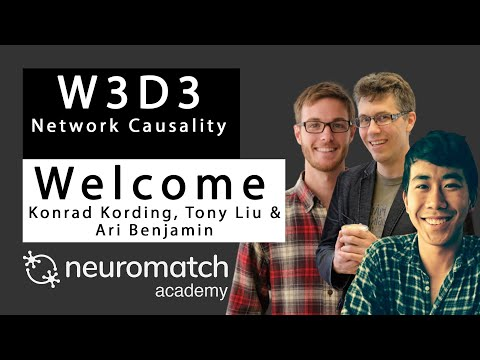

In [8]:
#@title Video 
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="AgLuaGgD9VE", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

If we are unable to observe the entire system, **omitted variable bias** becomes a problem.

Let's see how bad this really is. If we don't have access to all the neurons, and so therefore can't control for them, can we still get the causal effect?


## Visualizing subsets of the connectivity matrix

We first visualize different subsets of the connectivity matrix when we observe 75% of the neurons vs 25%

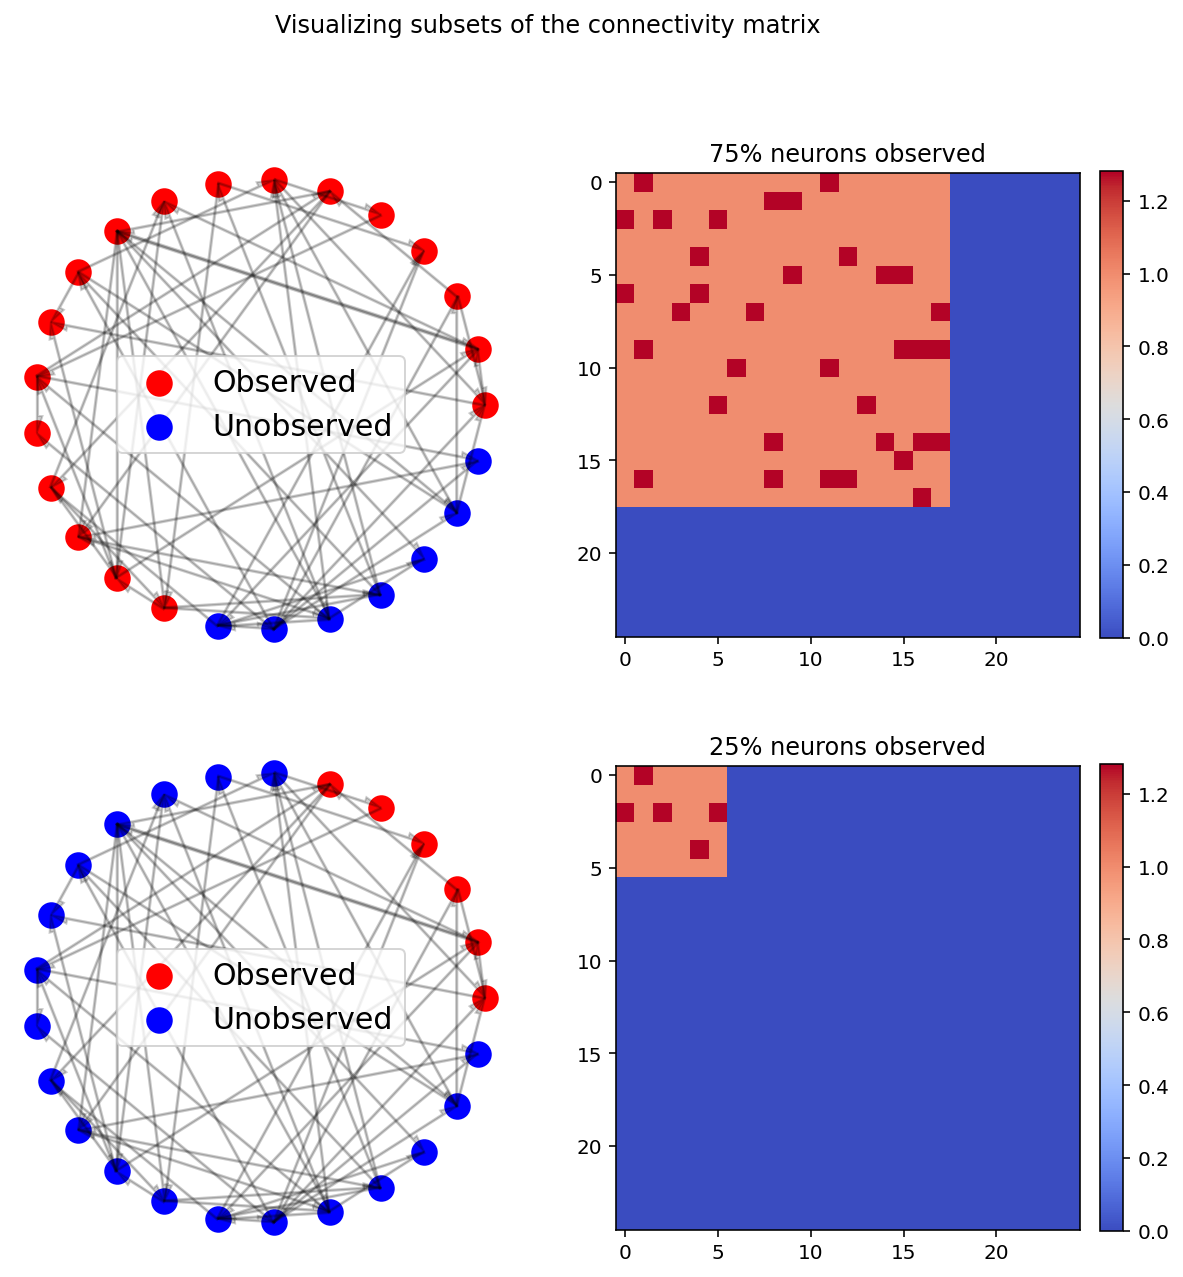

In [9]:
# @title Subsets of connectivity matrix
# Run this cell to visualize the subsets of variables we observe
n_neurons = 25
A = create_connectivity(n_neurons)

fig, axs = plt.subplots(2,2, figsize=(10,10))
ratio_observed = [0.75, 0.25] # the proportion of neurons observed in our system

for i, ratio in enumerate(ratio_observed):
    sel_idx = int(n_neurons*ratio)
    
    offset = np.zeros((n_neurons, n_neurons))
    axs[i,1].title.set_text("{}% neurons observed".format(int(ratio * 100)))
    offset[:sel_idx, :sel_idx] =  1 + A[:sel_idx, :sel_idx]
    im = axs[i, 1].imshow(offset, cmap="coolwarm", vmin=0, vmax=A.max()+1)
    plt.colorbar(im, ax=axs[i,1],fraction=0.046, pad=0.04)
    see_neurons(A,axs[i,0],ratio)

plt.suptitle("Visualizing subsets of the connectivity matrix")
plt.show()

## Regression performance as a function of the number of observed neurons

We will first change the number of observed neurons in the network and inspect the resulting estimates of connectivity in this interactive demo. How doees the estimated connectivity differ?

We will then inspect a plot of the correlation between true and estimated connectivity matrices vs the percent of neurons observed. 

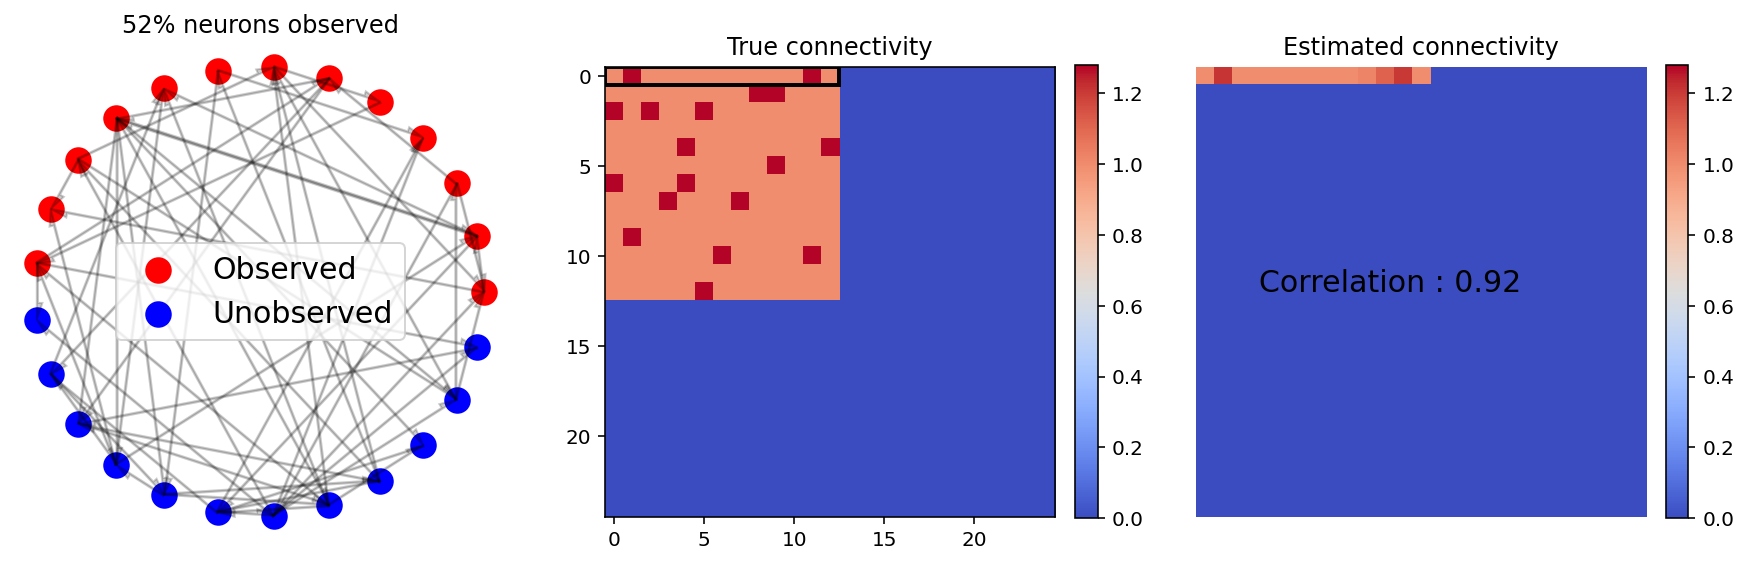

In [10]:
#@title Interactive Demo: Estimating connectivity with subsets of observed neurons
n_neurons = 25
A = create_connectivity(n_neurons, random_state=42)
X = simulate_neurons(A, 5000)

reg_args = {
    "fit_intercept": False,
    "alpha": 0.001
}

@widgets.interact
def plot_observed(n_observed=(1,n_neurons,1)):
  to_neuron = 0
  fig, axs = plt.subplots(1,3, figsize=(15,5))
  sel_idx = n_observed
  ratio = (n_observed)/n_neurons
  offset = np.zeros((n_neurons, n_neurons))
  axs[0].title.set_text("{}% neurons observed".format(int(ratio * 100)))
  offset[:sel_idx, :sel_idx] =  1 + A[:sel_idx, :sel_idx]
  im = axs[1].imshow(offset, cmap="coolwarm", vmin=0, vmax=A.max()+1)
  plt.colorbar(im, ax=axs[1],fraction=0.046, pad=0.04)
    
  see_neurons(A,axs[0],ratio)
  corr, R =  get_regression_corr(n_neurons, 
                                  A, 
                                  X, 
                                  ratio,
                                  reg_args,
                                  neuron_idx=to_neuron)  
  
  rect = patches.Rectangle((-.5,to_neuron-.5),n_observed,1,linewidth=2,edgecolor='k',facecolor='none')
  axs[1].add_patch(rect)
  big_R = np.zeros(A.shape)
  big_R[to_neuron, :sel_idx] =  1 + R
  im = axs[2].imshow(big_R, cmap="coolwarm", vmin=0, vmax=A.max()+1)
  plt.colorbar(im, ax=axs[2],fraction=0.046, pad=0.04)
    
  axs[2].text(3,12,"Correlation : {:.2f}".format(corr), size=15)
  axs[2].axis("off")
  axs[1].title.set_text("True connectivity")
  axs[2].title.set_text("Estimated connectivity")

simulating trial 1 of 3


simulating trial 2 of 3


simulating trial 3 of 3


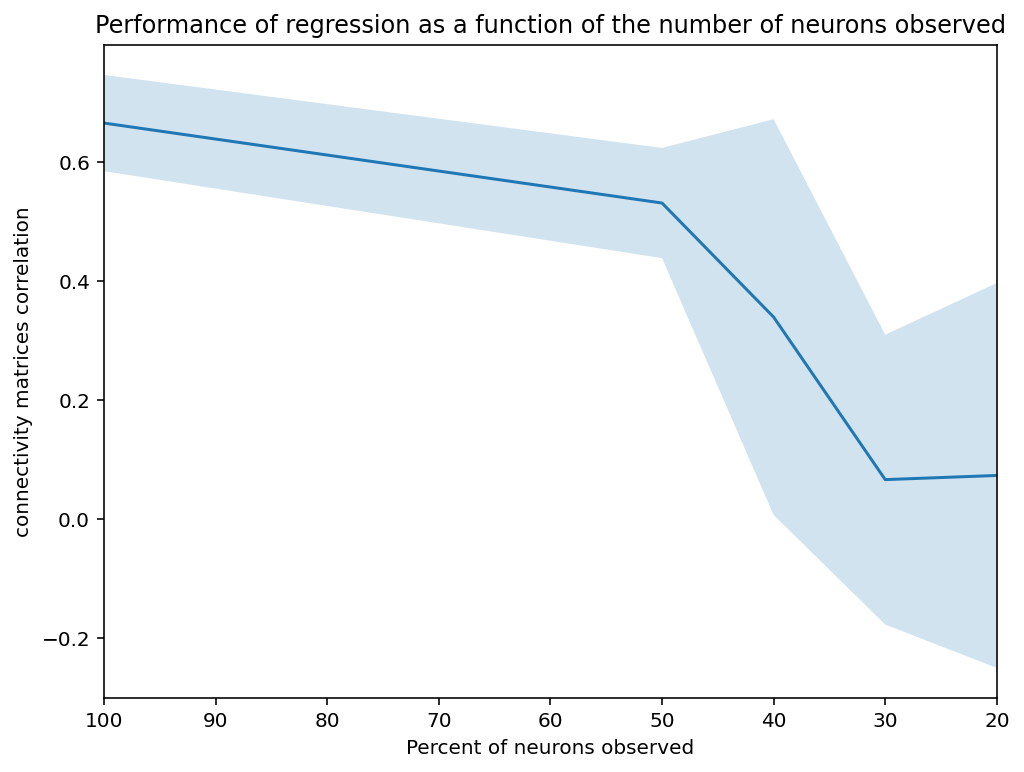

In [11]:
#@title Plot correlation vs. subsampling
import warnings
warnings.filterwarnings('ignore')

# we'll simulate many systems for various ratios of observed neurons
# NOTE: this will take about 45 seconds to run
n_neurons = 50
timesteps = 5000
ratio_observed = [1, 0.5, .4,.3,.2,] # the proportion of neurons observed in our system
n_trials = 3 # run it this many times to get variability in our results

reg_args = {
    "fit_intercept": False,
    "alpha": 0.001
}

corr_data = np.zeros((n_trials, len(ratio_observed)))
for trial in range(n_trials):

  A = create_connectivity(n_neurons, random_state=trial)
  X = simulate_neurons(A, timesteps)
  print("simulating trial {} of {}".format(trial+1, n_trials))
  
  
  for j, ratio in enumerate(ratio_observed):
      result,_ = get_regression_corr(n_neurons, 
                                    A, 
                                    X, 
                                    ratio,
                                    reg_args,
                                    neuron_idx=1)        

      corr_data[trial, j] = result

corr_mean = np.nanmean(corr_data, axis=0)
corr_std = np.nanstd(corr_data, axis=0)
plt.plot(np.asarray(ratio_observed)*100, corr_mean)
plt.fill_between(np.asarray(ratio_observed)*100,
                     corr_mean - corr_std,
                     corr_mean + corr_std,
                     alpha=.2)
plt.xlim([100, 20])
plt.xlabel("Percent of neurons observed")
plt.ylabel("connectivity matrices correlation")
plt.title("Performance of regression as a function of the number of neurons observed");

Video available at https://youtu.be/l_QefOJ1838


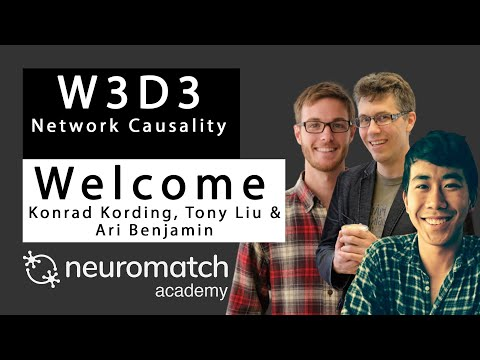

In [12]:
#@title Video 
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="l_QefOJ1838", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

# OPTIONAL Section: Granger Causality

**Please revisit this section AFTER you complete tutorial notebook 4**, if you have time.

One potential solution to temporal causation: [*Granger Causality*](https://en.wikipedia.org/wiki/Granger_causality).

But, this method still fails in the presence of unobserved variables.

We are testing whether a time series $X$ Granger-causes a time series $Y$ through a hypothesis test:

- the null hypothesis $H_0$: lagged values of $X$ do not help predict values of $Y$ 

- the alternative hypothesis $H_a$: lagged values of $X$ **do** help predict values of $Y$ 

Mechanically, this is accomplished by fitting autoregressive models for $y_{t}$. We fail to reject the hypothesis if none of the $x_{t-k}$ terms are retained as significant in the regression. For simplicity, we will consider only one time lag. So, we have:

$$
H_0: y_t = a_0 + a_1 y_{t-1} +\epsilon_t
$$

$$
H_a: y_t = a_0 + a_1 y_{t-1} + b_1 x_{t-1} +\epsilon_t
$$


### Exercise 2: Evaluate Granger causality

Complete the following definition to evaluate the Granger causality between our neurons. Then run the cells below to evaluate how well it works. You will use the `grangercausalitytests()` function imported from statsmodels 

### Suggestions

- use `help()` to check the function signature for `grangercausalitytests()`

In [13]:
def get_granger_causality(X, neuron_idx, alpha=0.05):
    """
    Estimates the lag-1 granger causality of the given neuron on the other neurons in the system.

    Args:
        X (np.ndarray): the matrix holding our dynamical system of shape (n_neurons, timesteps)
        neuron_idx (int): the index of the neuron we want to estimate granger causality for
        observed_ratio (float): the proportion of n_neurons observed, must be betweem 0 and 1.
        regression_args (dict): dictionary of lasso regression arguments and hyperparameters

    Returns:
        A tuple (reject_null, p_vals)
        reject_null (list): a binary list of length n_neurons whether the null was 
            rejected for the selected neuron granger causing the other neurons
        p_vals (list): a list of the p-values for the corresponding Granger causality tests
    """
    n_neurons = X.shape[0]
    max_lag = 1
    alpha = alpha #/ (n_neurons* max_lag) # Bonferroni multiple comparisons correction

    reject_null = []   
    p_vals = []

    for target_neuron in range(n_neurons):
        ts_data = X[[neuron_idx, target_neuron], :].transpose()

        ########################################################################
        ## Insert your code here to run Granger causality tests.
        ##
        ## Function Hints:
        ##     Pass the ts_data defined above as the first argument
        ##     Granger causality -> grangercausalitytests
        ## Fill out this function and then remove
        raise NotImplementedError('Complete get_granger_causality function')
        ########################################################################
        res = grangercausalitytests(...)
        
        # gets the p-value for the log-ratio test 
        pval = res[1][0]['lrtest'][1]

        p_vals.append(pval)
        reject_null.append(int(pval < alpha))

    return reject_null, p_vals

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D3_NetworkCausality/solutions/W3D3_Tutorial3_Solution_8792fb84.py)



## Granger causality in small systems




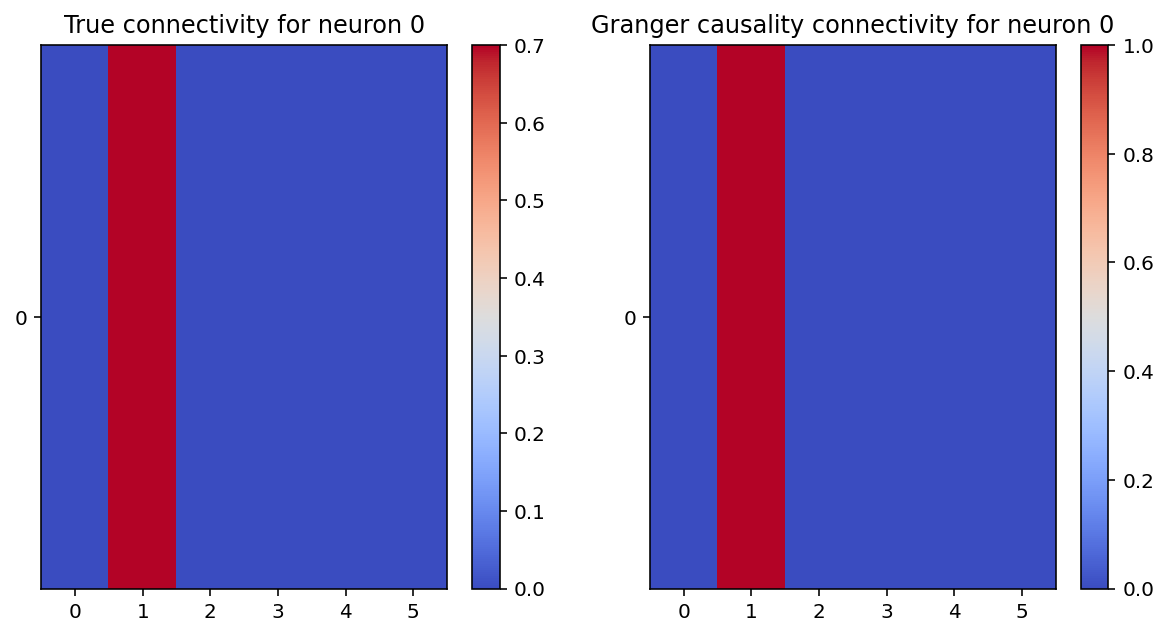

In [15]:
# we'll check whether the first neuron Granger-causes the other neurons
n_neurons = 6
timesteps = 5000
random_state = 42
neuron_idx = 0
A = create_connectivity(n_neurons, random_state)
X = simulate_neurons(A, timesteps, random_state)

fig, axs = plt.subplots(1,2, figsize=(10,5))

im = axs[0].imshow(A[[neuron_idx], :], cmap='coolwarm', aspect='auto')
plt.colorbar(im, ax = axs[0])
axs[0].set_yticks([0])
axs[0].title.set_text("True connectivity for neuron {}".format(neuron_idx))

# get granger causality estimates
reject_null, p_vals = get_granger_causality(X, neuron_idx)
im = axs[1].imshow([reject_null], cmap='coolwarm', aspect='auto')
plt.colorbar(im, ax = axs[1])
axs[1].set_yticks([0])
axs[1].title.set_text("Granger causality connectivity for neuron {}".format(neuron_idx))

Looks good! Let's also check the correlation between Granger estimates and the true connectivity.


In [16]:
np.corrcoef(A[neuron_idx,:], reject_null)[1,0]

1.0

When we have a small system, we correctly identify the causality of neuron 0.

Video available at https://youtu.be/Ys_yozyll-k


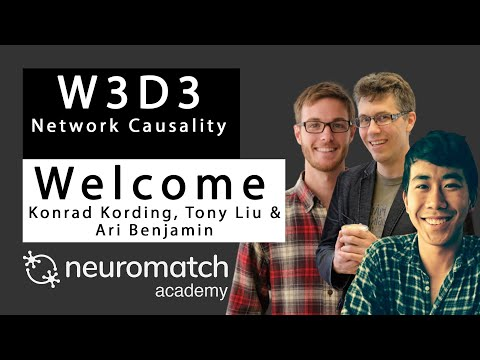

In [17]:
#@title Video 
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="Ys_yozyll-k", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

## Granger causality in large systems

Now, lets run Granger causality on a good number of neurons to get an intuition on how well or poorly causal inference with GC works as a function of the number of parameters in a fully observed system.
Run the following Granger causality code on a small system (10 neurons) and see how GC works well. And run it with 100 neurons. Does it still work well. How does the number of timesteps matter?

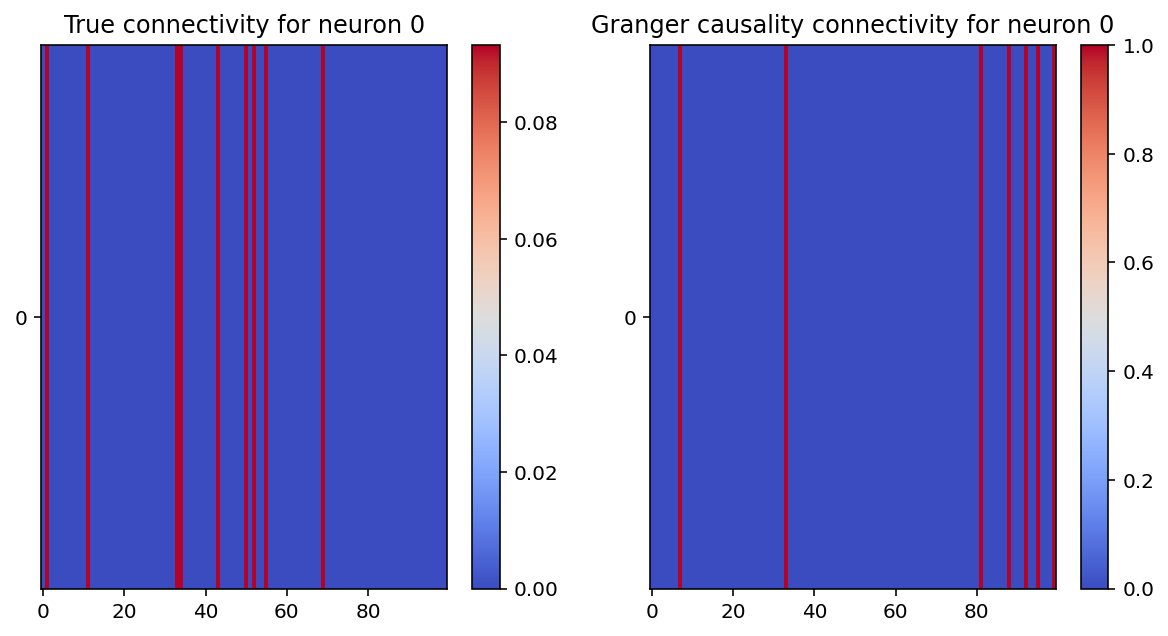

In [18]:
n_neurons = 100
timesteps = 5000
random_state = 42
neuron_idx = 0
A = create_connectivity(n_neurons, random_state)
X = simulate_neurons(A, timesteps, random_state)

fig, axs = plt.subplots(1,2, figsize=(10,5))

im = axs[0].imshow(A[[neuron_idx], :], cmap='coolwarm', aspect='auto')
plt.colorbar(im, ax = axs[0])
axs[0].set_yticks([0])

axs[0].title.set_text("True connectivity for neuron {}".format(neuron_idx))

# get granger causality estimates
reject_null, p_vals = get_granger_causality(X, neuron_idx)
im = axs[1].imshow([reject_null], cmap='coolwarm', aspect='auto')
plt.colorbar(im, ax = axs[1])
axs[1].set_yticks([0])

axs[1].title.set_text("Granger causality connectivity for neuron {}".format(neuron_idx))

Let's again check the correlation between the Granger estimates and the true connectivity.

In [19]:
np.corrcoef(A[neuron_idx,:], reject_null)[1,0]

0.050672143847840266

Video available at https://youtu.be/RBdO6sh3YVI


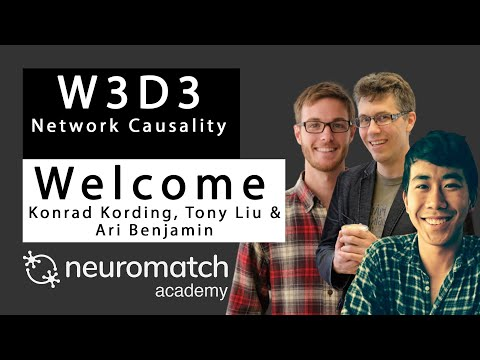

In [20]:
#@title Video 
# Insert the ID of the corresponding youtube video
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="RBdO6sh3YVI", width=854, height=480, fs=1)
print("Video available at https://youtu.be/" + video.id)
video

# Summary

In this tutorial, we explored:

1) Using regression for estimating causality

2) The problem of ommitted variable bias

3) Using Granger causality for estimating causality

# Appendix

## Notes on Granger Causality

Here we considered bivariate Granger causality -- for each pair of neurons $A, B$, does one Granger-cause the other? You might wonder whether considering more variables will help with estimation. *Conditional Granger Causality* is a technique that allows for a multivariate system, where we test whether $A$ Granger-causes $B$ conditional on the other variables in the system. 

Even after controlling for variables in the system, conditional Granger causality will also likely perform poorly as our system gets larger. Plus, measuring the additional variables to condition on may be infeasible in practical applications, which would introduce omitted variable bias as we saw in the regression exercise.

One takeaway here is that as our estimation procedures become more sophisticated, they also become more difficult to interpret. We always need to understand the methods and the assumptions that are made.